In [60]:
!pip install -qU langchain[google-genai]

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [9]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [10]:
from google.colab import userdata
API_KEY = userdata.get('GOOGLE_API_KEY')
PROJECT_ID = userdata.get('GOOGLE_PROJ_ID1')

In [25]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt
import pickle

In [12]:
# Load the data
df = pd.read_csv('AI_agent_train_sepsis.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198433 entries, 0 to 198432
Data columns (total 57 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         198433 non-null  int64  
 1   bloc               198433 non-null  float64
 2   icustayid          198433 non-null  float64
 3   charttime          198433 non-null  float64
 4   gender             198433 non-null  float64
 5   age                198433 non-null  float64
 6   elixhauser         198433 non-null  float64
 7   re_admission       198433 non-null  float64
 8   Weight_kg          198433 non-null  float64
 9   GCS                198433 non-null  float64
 10  HR                 198433 non-null  float64
 11  SysBP              198433 non-null  float64
 12  MeanBP             198433 non-null  float64
 13  DiaBP              198433 non-null  float64
 14  RR                 198433 non-null  float64
 15  SpO2               198433 non-null  float64
 16  Te

In [13]:
# Treat records with the same icustayid as time series by sorting in that order
df = df.sort_values(by=['icustayid', 'charttime'])

In [14]:
def count_records_w_missing_features(df):
  patient_ids = df['icustayid'].unique()
  num_na_records = 0

  for pid in patient_ids:
    patient_record = df[df['icustayid'] == pid]
    if patient_record.isna().values.any():
      num_na_records += 1

  print("Number of records with NaN values:", num_na_records)
  print("Total number of records:", len(patient_ids))

In [15]:
feature_cols = [col for col in df.columns if col not in ['icustayid', 'charttime', 'mortality_90d', 'bloc', 'Unnamed: 0']]

# Since 0 values in some columns can indicate missing data, investigate how many 0s each column has
for col in feature_cols:
  num_0_values = (df[col] == 0).sum()
  print(col, "Number of 0 values:", num_0_values)
  print()

# Replace 0 values with NaN if 0 inidicates missing value
cols_where_0_is_ok = ['gender', 're_admission', 'mechvent', 'median_dose_vaso', 'max_dose_vaso',
                      'input_total', 'input_4hourly', 'output_total', 'output_4hourly', 'SOFA', 'SIRS']
cols_where_0_means_missing = [col for col in feature_cols if col not in cols_where_0_is_ok]
df[cols_where_0_means_missing] = df[cols_where_0_means_missing].replace(0, np.nan)

gender Number of 0 values: 110453

age Number of 0 values: 0

elixhauser Number of 0 values: 6512

re_admission Number of 0 values: 183830

Weight_kg Number of 0 values: 153

GCS Number of 0 values: 0

HR Number of 0 values: 2

SysBP Number of 0 values: 8

MeanBP Number of 0 values: 2

DiaBP Number of 0 values: 7

RR Number of 0 values: 30

SpO2 Number of 0 values: 0

Temp_C Number of 0 values: 0

FiO2_1 Number of 0 values: 0

Potassium Number of 0 values: 0

Sodium Number of 0 values: 0

Chloride Number of 0 values: 0

Glucose Number of 0 values: 0

BUN Number of 0 values: 2

Creatinine Number of 0 values: 16

Magnesium Number of 0 values: 3

Calcium Number of 0 values: 5

Ionised_Ca Number of 0 values: 3

CO2_mEqL Number of 0 values: 0

SGOT Number of 0 values: 11

SGPT Number of 0 values: 24

Total_bili Number of 0 values: 610

Albumin Number of 0 values: 0

Hb Number of 0 values: 2

WBC_count Number of 0 values: 3

Platelets_count Number of 0 values: 0

PTT Number of 0 values: 3

P

In [16]:
count_records_w_missing_features(df)

Number of records with NaN values: 11579
Total number of records: 15124


In [17]:
# Imputation Strategy Number 1: Forward Fill + Backup: Backward Fill + Second Backup: Group Mean + Third Backup: Global Mean
df_imp_fill = df.copy()
df_imp_fill = df_imp_fill.groupby('icustayid').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)

for col in feature_cols:
  df_imp_fill[col] = df_imp_fill.groupby('icustayid')[col].transform(
      lambda x: x.fillna(x.mean())
  )

for col in feature_cols:
  df_imp_fill[col] = df_imp_fill[col].fillna(df_imp_fill[col].mean())

<ipython-input-17-d5219c2502b9>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imp_fill = df_imp_fill.groupby('icustayid').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)


In [18]:
# Imputation Strategy Number 2: Interpolation
df_imp_interp = df.copy()
df_imp_interp['charttime'] = pd.to_datetime(df_imp_interp['charttime'])
df_imp_interp = df_imp_interp.groupby('icustayid').apply(
    lambda group: group.set_index('charttime').interpolate(method='time').reset_index()
).reset_index(drop=True)

<ipython-input-18-16c468beee16>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imp_interp = df_imp_interp.groupby('icustayid').apply(


In [19]:
count_records_w_missing_features(df_imp_fill)
count_records_w_missing_features(df_imp_interp)

Number of records with NaN values: 0
Total number of records: 15124
Number of records with NaN values: 5826
Total number of records: 15124


In [20]:
def extract_features(df, feature_cols):
  feature_list = []
  labels = []

  for group_id, group in df.groupby('icustayid'):
    features = {}
    for col in feature_cols:
      features[f'{col}_mean'] = group[col].mean()
      features[f'{col}_std'] = group[col].std()
      features[f'{col}_min'] = group[col].min()
      features[f'{col}_max'] = group[col].max()
      features[f'{col}_last'] = group[col].iloc[-1]

    label = group['mortality_90d'].iloc[0]
    labels.append(label)
    feature_list.append(features)

  X = pd.DataFrame(feature_list)
  y = np.array(labels)
  return X, y

In [21]:
X, y = extract_features(df, feature_cols)
X_imp_fill, y_imp_fill = extract_features(df_imp_fill, feature_cols)
X_imp_interp, y_imp_interp = extract_features(df_imp_interp, feature_cols)

def count_rows_w_nans(X):
  nan_counts_per_row = X.isnull().sum(axis=1)
  rows_with_nan = nan_counts_per_row > 0
  print("Number of rows with NaN:", rows_with_nan.sum())
  print("Total number of rows:", len(X))

count_rows_w_nans(X)
count_rows_w_nans(X_imp_fill)
count_rows_w_nans(X_imp_interp)

Number of rows with NaN: 3420
Total number of rows: 15124
Number of rows with NaN: 243
Total number of rows: 15124
Number of rows with NaN: 1072
Total number of rows: 15124


In [22]:
# Train Random Forest and XGBoost on non-imputed dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = RandomForestClassifier(
  n_estimators=100,
  max_depth=10,
  class_weight='balanced',
  random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Random Forest on No Imputation:")
print(classification_report(y_test, y_pred))

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("XGBoost on No Imputation:")
print(classification_report(y_test, y_pred))

Random Forest on No Imputation:
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      1869
         1.0       0.53      0.38      0.44       400

    accuracy                           0.83      2269
   macro avg       0.70      0.65      0.67      2269
weighted avg       0.81      0.83      0.82      2269



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:09:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost on No Imputation:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      1869
         1.0       0.64      0.23      0.34       400

    accuracy                           0.84      2269
   macro avg       0.75      0.60      0.63      2269
weighted avg       0.82      0.84      0.81      2269



In [23]:
# Train Random Forest and XGBoost on dataset imputed using Strategy 1 (Fill + Mean)
X_train, X_test, y_train, y_test = train_test_split(X_imp_fill, y_imp_fill, test_size=0.15, random_state=42)

mask = ~np.isnan(X_train).any(axis=1)

# Apply the mask to X and y
X_train = X_train[mask]
y_train = y_train[mask]

sm = SMOTE(sampling_strategy=1.0)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

model = RandomForestClassifier(
  n_estimators=100,
  max_depth=10,
  class_weight='balanced',
  random_state=42
)

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("Random Forest on Imputation 1:")
print(classification_report(y_test, y_pred))

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("XGBoost on Imputation 1:")
print(classification_report(y_test, y_pred))

Random Forest on Imputation 1:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      1869
         1.0       0.47      0.43      0.45       400

    accuracy                           0.82      2269
   macro avg       0.68      0.67      0.67      2269
weighted avg       0.81      0.82      0.81      2269



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:12:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost on Imputation 1:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      1869
         1.0       0.53      0.29      0.37       400

    accuracy                           0.83      2269
   macro avg       0.69      0.62      0.64      2269
weighted avg       0.80      0.83      0.81      2269



In [24]:
# Train Random Forest and XGBoost on dataset imputed using Strategy 2 (Interpolation)
X_train, X_test, y_train, y_test = train_test_split(X_imp_interp, y_imp_interp, test_size=0.15, random_state=42)

mask = ~np.isnan(X_train).any(axis=1)

# Apply the mask to X and y
X_train = X_train[mask]
y_train = y_train[mask]

sm = SMOTE(sampling_strategy=1.0)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

model = RandomForestClassifier(
  n_estimators=100,
  max_depth=10,
  class_weight='balanced',
  random_state=42
)

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("Random Forest on Imputation 2:")
print(classification_report(y_test, y_pred))

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("XGBoost on Imputation 2:")
print(classification_report(y_test, y_pred))

Random Forest on Imputation 2:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      1869
         1.0       0.47      0.41      0.44       400

    accuracy                           0.82      2269
   macro avg       0.68      0.66      0.67      2269
weighted avg       0.81      0.82      0.81      2269



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:14:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost on Imputation 2:
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.91      1869
         1.0       0.57      0.30      0.39       400

    accuracy                           0.84      2269
   macro avg       0.72      0.63      0.65      2269
weighted avg       0.81      0.84      0.82      2269



In [26]:
# Use the best training configuration

mask = ~np.isnan(X_imp_interp).any(axis=1)

# Apply the mask to X and y
X_imp_interp = X_imp_interp[mask]
y_imp_interp = y_imp_interp[mask]

sm = SMOTE(sampling_strategy=1.0)
X_resampled, y_resampled = sm.fit_resample(X_imp_interp, y_imp_interp)

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_resampled, y_resampled)
filename = 'mortality_prediction_model.sav'
pickle.dump(model, open(filename, 'wb'))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:18:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


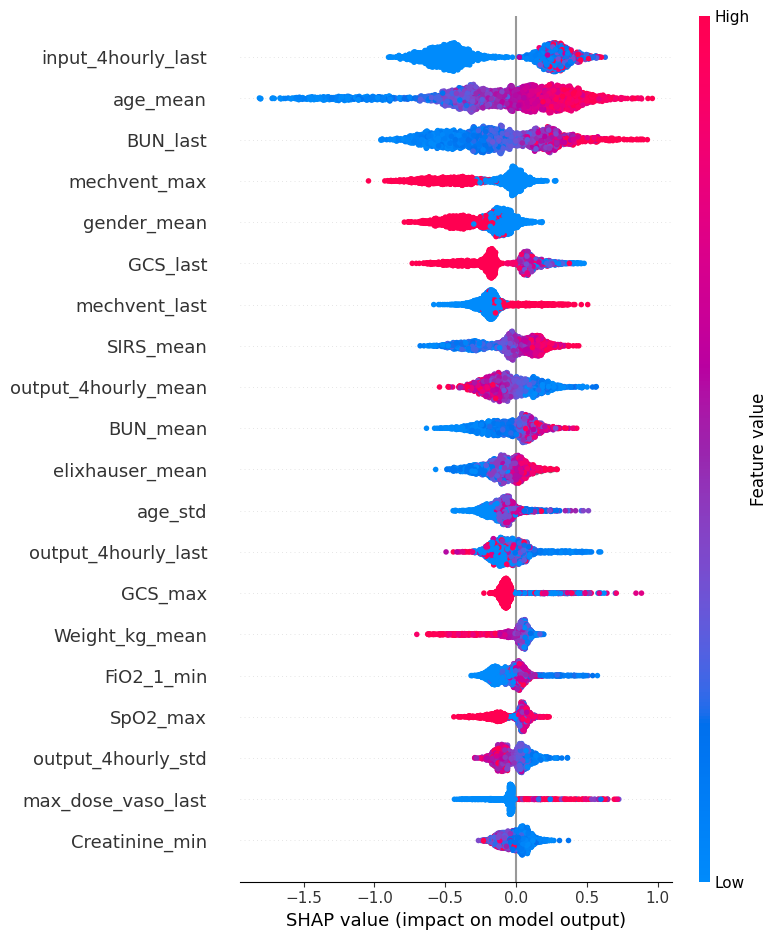

In [27]:
# Use SHAP to find out model importance

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=True)

In [28]:
# Load patients from test dataset
test_df = pd.read_csv('AI_agent_test_sepsis_features.csv')
test_df = test_df.sort_values(by=['icustayid', 'charttime'])

feature_cols = [col for col in test_df.columns if col not in ['icustayid', 'charttime', 'mortality_90d', 'bloc', 'Unnamed: 0']]

# Replace 0 values with NaN if 0 inidicates missing value
cols_where_0_is_ok = ['gender', 're_admission', 'mechvent', 'median_dose_vaso', 'max_dose_vaso',
                      'input_total', 'input_4hourly', 'output_total', 'output_4hourly', 'SOFA', 'SIRS']
cols_where_0_means_missing = [col for col in feature_cols if col not in cols_where_0_is_ok]
test_df[cols_where_0_means_missing] = test_df[cols_where_0_means_missing].replace(0, np.nan)

# Imputation Strategy Number 2: Interpolation
test_df_imp = test_df.copy()
test_df_imp['charttime'] = pd.to_datetime(test_df_imp['charttime'])
test_df_imp = test_df_imp.groupby('icustayid').apply(
    lambda group: group.set_index('charttime').interpolate(method='time').reset_index()
).reset_index(drop=True)

def extract_features_from_test(test_df, feature_cols):
  feature_list = []

  for group_id, group in df.groupby('icustayid'):
    features = {}
    for col in feature_cols:
      features[f'{col}_mean'] = group[col].mean()
      features[f'{col}_std'] = group[col].std()
      features[f'{col}_min'] = group[col].min()
      features[f'{col}_max'] = group[col].max()
      features[f'{col}_last'] = group[col].iloc[-1]

    feature_list.append(features)

  X = pd.DataFrame(feature_list)
  return X

test_X = extract_features_from_test(test_df, feature_cols)
test_X_imp = extract_features_from_test(test_df_imp, feature_cols)
test_y_pred = model.predict(test_X)
test_y_imp_pred = model.predict(test_X_imp)

explainer = shap.TreeExplainer(model)
shap_values = explainer(test_X)
shap_values_imp = explainer(test_X_imp)

<ipython-input-28-14030d13f40b>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df_imp = test_df_imp.groupby('icustayid').apply(


In [52]:
mortality_explainer = genai.GenerativeModel(
    model_name="gemini-1.5-flash",
    system_instruction=[
        "You are an AI chatbot that explains the results of another AI model that analyzes EHR records.",
        "You will be given a mortality score (1 means they will die in 90 days, 0 means they will not).",
        "Then, you will be given a list of features from the EHR data that were most important in deciding the mortality.",
        "Explain the mortality score and features to a doctor in natural language. Sound confident."
    ],
)

In [102]:
def get_patient_records(icustayid: int):
  """Get patient records according to their icustayid

  Args:
    icustayid: The ID of a patient's ICU stay i.e. a patient's unique ID

  Returns:
    A dataframe of rows which share the same icustayid
  """
  global test_df
  patient_records = test_df[test_df['icustayid'] == icustayid]
  print(patient_records)
  return patient_records

def predict_patient_mortality(icustayid: int):
  """Predict a patient's predicted mortality within 90 days (i.e. mortality_90d)

  Args:
    icustayid: The ID of a patient's ICU stay i.e. a patient's unique ID
  """
  global test_df, mortality_explainer
  unique_ids = test_df['icustayid'].unique()
  indices = np.where(unique_ids == icustayid)
  idx = indices[0][0]
  mortality_pred = test_y_pred[idx]
  mortality_pred_imp = test_y_imp_pred[idx]

  # Create feature to shap value dict
  patient_shap_values = shap_values[idx]
  patient_shap_values_imp = shap_values_imp[idx]
  feature_shap_dict = {}
  for i in range(len(test_X.columns)):
    feature_shap_dict[test_X.columns[i]] = patient_shap_values.values[i]

  shap.plots.waterfall(patient_shap_values, max_display=10)
  top_10_shaps = sorted(feature_shap_dict.items(), key=lambda item: abs(item[1]), reverse=True)[:10]
  top_10_features = [key for key, value in top_10_shaps]

  chat = mortality_explainer.start_chat()

  message = "The mortality prediction without imputing was " + str(mortality_pred) + ". "
  message += "The mortality prediction with imputing was " + str(mortality_pred_imp) + ". "
  message += "These were the top 10 features according to SHAP value: "
  for ft in top_10_features:
    message += ft + ", "
  message += "Please explain these results in natural language"
  response = chat.send_message(message).text
  print(response)

  return mortality_pred

In [105]:
import google.generativeai as genai
genai.configure(api_key=API_KEY)

import vertexai
from vertexai import agent_engines
vertexai.init(api_key=API_KEY, project=PROJECT_ID)
model = "gemini-2.0-flash"
agent = agent_engines.LangchainAgent(
    model=model,                # Required.
    tools=[get_patient_records, predict_patient_mortality],  # Optional.
)

In [106]:
response = agent.query(
    input="Get the patient records of icustayid = 200014"
)
response

    Unnamed: 0  bloc  icustayid     charttime  gender       age  elixhauser  \
7           23   1.0   200014.0  4.264269e+09     0.0  30946.97         2.0   
8           24   2.0   200014.0  4.264284e+09     0.0  30946.97         2.0   
9           25   3.0   200014.0  4.264298e+09     0.0  30946.97         2.0   
10          26   4.0   200014.0  4.264312e+09     0.0  30946.97         2.0   
11          27   5.0   200014.0  4.264327e+09     0.0  30946.97         2.0   
12          28   6.0   200014.0  4.264341e+09     0.0  30946.97         2.0   
13          29   7.0   200014.0  4.264356e+09     0.0  30946.97         2.0   
14          30   8.0   200014.0  4.264370e+09     0.0  30946.97         2.0   
15          31   9.0   200014.0  4.264384e+09     0.0  30946.97         2.0   
16          32  10.0   200014.0  4.264399e+09     0.0  30946.97         2.0   
17          33  14.0   200014.0  4.264456e+09     0.0  30946.97         2.0   

    re_admission  Weight_kg        GCS  ...   PaO2_

{'input': 'Get the patient records of icustayid = 200014',
 'output': 'Here are the patient records for icustayid 200014.'}

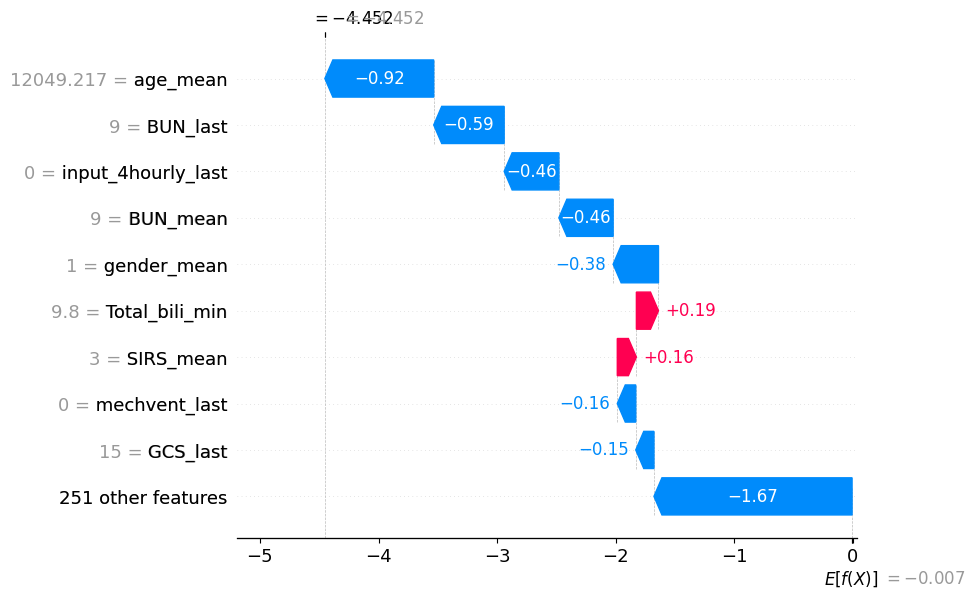

Based on our analysis of the patient's electronic health record (EHR) data, the model predicts a very low risk of mortality within the next 90 days.  Both analyses—with and without imputation of missing data—consistently yielded a mortality score of 0, indicating a strong likelihood of survival.

Let's examine the key features that contributed to this prediction.  The model identified several crucial factors:

* **Age:**  The patient's average age (age_mean) is a significant factor, as older age is generally associated with increased mortality risk.  However, in this specific case, the model has likely weighed other, more favorable factors more heavily.

* **Blood Urea Nitrogen (BUN):** Both the mean (BUN_mean) and last recorded BUN level (BUN_last) were important.  This indicates that the patient's kidney function, as reflected in BUN levels, is within a healthy range for their age and overall health profile.  Stable or improved BUN is a positive prognostic indicator.

* **Fluid Input

{'input': 'Get the patient mortality of icustayid = 200014',
 'output': 'The patient mortality within 90 days for icustayid 200014 is 0.\n'}

In [107]:
response = agent.query(
    input="Get the patient mortality of icustayid = 200014"
)
response